# Exploring Superfund Site Data

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import mapping

import warnings
warnings.simplefilter(action='ignore')

In [3]:
#change default figure size
plt.rcParams['figure.figsize'] = (20, 10)

Use command line to first convert Superfund Data downloaded in an Esri Geodatabase format into a shapefile,

`ogr2ogr -f "ESRI Shapefile" superfund-sites SuperfundSites.gdb`

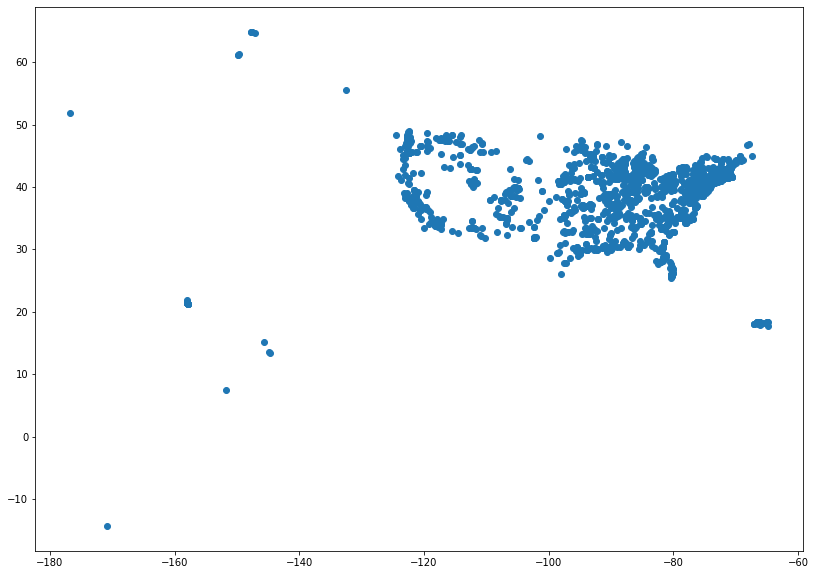

In [4]:
#read superfund site shapefile in
gdf = gpd.read_file('data/superfund-sites/SuperfundSites.shp')

#plot data to visualize
%matplotlib inline
gdf.plot(figsize=(20,10));

In [5]:
#inspect attribute table
gdf.sample(10)

,siteID,EPASiteID,EPARegion,siteName,streetAddr,cityName,state,zipCode,countyName,FIPSCode,congressio,nationalPr,nonNationa,federalFac,geometry
1074,502256,MID005341714,5,Hi-Mill Manufacturing Co.,1704 Highland Rd,Highland,MI,48356,Oakland,26125.0,11.0,Currently on the Final NPL,None,N,POINT (-83.59308 42.64983)
658,300444,PAD000436261,3,Centre County Kepone,201 Struble Road,State College Borough,PA,16801,Centre,42027.0,5.0,Currently on the Final NPL,None,N,POINT (-77.80833 40.82361)
479,204061,NJD011770013,2,Matteo & Sons Inc.,1708 US Rt. 130,Thorofare,NJ,08086,Gloucester,34015.0,1.0,Currently on the Final NPL,None,N,POINT (-75.17270 39.85559)
498,204306,NJD981186828,2,Sun Cleaners,2213 Route 35,Wall Twp.,NJ,08750,Monmouth,34025.0,NaN,Site is Part of NPL Site,None,N,POINT (-74.06667 40.13194)
133,101429,RI3170022112,1,DOD/NETC/Old Fire Fighting Training Area,Coasters Harbor Island,Newport,RI,02840,Newport,44005.0,1.0,Site is Part of NPL Site,None,Y,POINT (-71.32000 41.51000)
2170,1001230,IDD984666024,10,Triumph Mine Tailings Piles,Postal Address Is Unavailable For The Site,Triumph,ID,83333,Blaine,16013.0,2.0,Removed from Proposed NPL,Other Cleanup Activity: State-Lead Cleanup,N,POINT (-114.25444 43.64500)
1870,700468,KSD007135429,7,Hydro-Flex Inc.,2101 NW Brickyard Rd,Topeka,KS,66618,Shawnee,20177.0,2.0,Deleted from the Final NPL,None,N,POINT (-95.72579 39.08708)
1900,902793,CA8570024143,9,Mather Air Force Base (AC&W Disposal Site),Mather Air Force Base,Mather,CA,95655,Sacramento,6067.0,NaN,Currently on the Final NPL,None,Y,POINT (-121.29720 38.55695)
79,101145,NHD980671002,1,Savage Municipal Water Supply,Near Rt 101,Milford,NH,03055,Hillsborough,33011.0,2.0,Currently on the Final NPL,None,N,POINT (-71.68840 42.84180)
1573,706132,MON000706132,7,Washington County Lead District - Palmer,Hwy 651A and Hwy Z Intersection,Palmer,MO,63664,Washington,29221.0,6.0,Site is Part of NPL Site,None,N,POINT (-90.99029 37.82246)


In [6]:
#inspect national priority status further
gdf['nationalPr'].unique()

array(['Currently on the Final NPL', 'Proposed for NPL',
       'Site is Part of NPL Site', 'Deleted from the Final NPL',
       'Removed from Proposed NPL', 'Withdrawn from the Final NPL'],
      dtype=object)

I received a few warnings about field names truncating when converting the geodatabase to a shapefile, but I can still make out most of the field names except for "nonNationa". 

Unfortunately there is not a whole lot of data here. We have basic location information (EPA region, site name, address, county, etc.) but no data on what type of threats each site poses.

The field "nationalPr" is worth paying attention to, as this lets us know which sites are 'active'. This field tells us whether the site is proposed for NPL, currently on NPL, or deleted or withdrawn from NPL. According to the EPA's [Superfund Site](https://www.epa.gov/superfund/superfund-national-priorities-list-npl), "The National Priorities List (NPL) is the list of sites of national priority among the known releases or threatened releases of hazardous substances, pollutants, or contaminants throughout the United States and its territories." Sites are deleted from the NPL if the EPA "...determines that no further response is required to protect human health or the environment."  I can consider filtering out the deleted sites, or at least differentiating between these when mapping them.

In [7]:
#create subsets of data to explore sites based on their NPL status
current = gdf[(gdf['nationalPr'] == 'Currently on the Final NPL') | (gdf['nationalPr'] == 'Site is Part of NPL Site')]
proposed = gdf[(gdf['nationalPr'] == 'Proposed for NPL')]
deleted = gdf[(gdf['nationalPr'] == 'Deleted from the Final NPL') | (gdf['nationalPr'] == 'Withdrawn from the Final NPL') | (gdf['nationalPr'] == 'Removed from Proposed NPl')]

print("Current NPL sites: ", current.shape[0])
print("Proposed for NPL: ", proposed.shape[0])
print("Deleted or Withdrawn from NPL: ", deleted.shape[0])

Current NPL sites:  1711
Proposed for NPL:  55
Deleted or Withdrawn from NPL:  397


<function print>

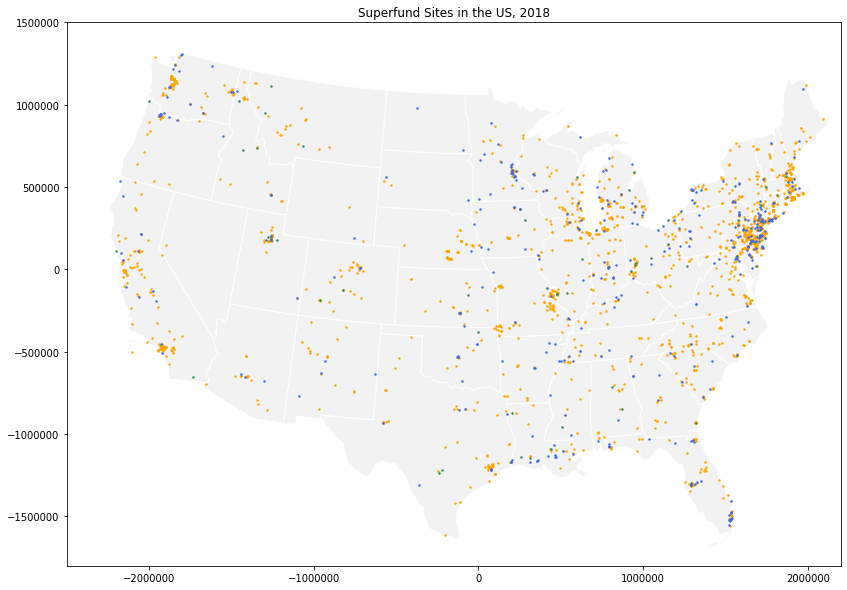

In [8]:
#plot superfund sites based on NPL status over state basemap to visualize distribution
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')

#project each layer to Albers Equal Conic for visualization
states_equal = states.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
current_equal = current.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
proposed_equal = proposed.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
deleted_equal = deleted.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

#plot projected data
fig, ax = plt.subplots(figsize=(20,10))

states_equal.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0)
current_equal.plot(ax=ax, color='orange', zorder=1, markersize=2);
proposed_equal.plot(ax=ax, color='seagreen', zorder=1, markersize=2);
deleted_equal.plot(ax=ax, color='royalblue', zorder=1, markersize=2);


ax.set(xlim=(-2500000,2200000), ylim=(-1800000,1500000), title='Superfund Sites in the US, 2018');

print

In [10]:
npl = gdf[(gdf['nationalPr'] == 'Currently on the Final NPL') | (gdf['nationalPr'] == 'Site is Part of NPL Site') | (gdf['nationalPr'] == 'Proposed for NPL')]

In [11]:
npl.to_file("data/superfund-sites.geojson", driver='GeoJSON')

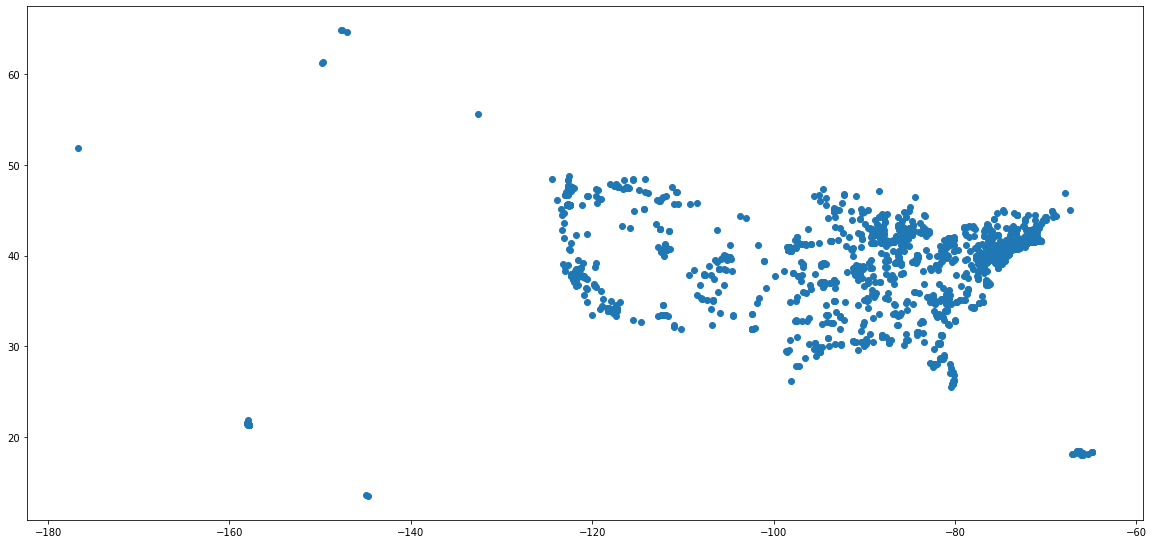

In [13]:
superfund = gpd.read_file('data/superfund-sites.geojson')
superfund.plot(figsize=(20,10));